In [2]:
import mnist_loader
import network
import numpy as np
from matplotlib import pyplot as plt

In [3]:
training_data, validation_data, test_data,train_ae = mnist_loader.load_data_wrapper()

In [4]:
net = network.Network([784, 30, 10], cost=network.CrossEntropyCost)
net.large_weight_initializer()
net.SGD(training_data, 5, 10, 0.5)
#evaluation_data=test_data , monitor_evaluation_accuracy=True

Epoch 0 training complete

Epoch 1 training complete

Epoch 2 training complete

Epoch 3 training complete

Epoch 4 training complete



([], [], [], [])

In [41]:
test_in = np.transpose([np.squeeze(i[0]) for i in test_data])
posteriors = net.feedforward(test_in)
test_pred = np.argmax(posteriors,0)


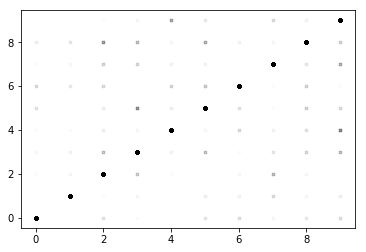

In [59]:
test_out = [i[1] for i in test_data]
plt.plot(test_out,test_pred,'k.',alpha=.01)

plt.show()

# Try autoendoder Network

In [26]:
net_ae = network.Network([784, 30,5,30, 784], cost=network.QuadraticCost)
net_ae.large_weight_initializer()
net_ae.SGD(train_ae, 10, 10, 0.5)

Epoch 0 training complete

Epoch 1 training complete

Epoch 2 training complete

Epoch 3 training complete

Epoch 4 training complete

Epoch 5 training complete

Epoch 6 training complete

Epoch 7 training complete

Epoch 8 training complete

Epoch 9 training complete



([], [], [], [])

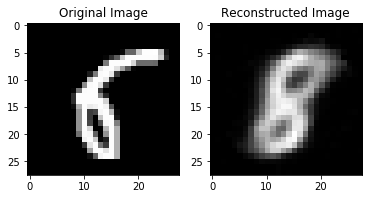

In [34]:
in_dat  = train_ae[11][0]
out_dat = net_ae.feedforward(in_dat)

plt.subplot(1,2,1)
plt.imshow(np.reshape(in_dat,(28,28)),cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(np.reshape(out_dat,(28,28)),cmap='gray')
plt.title('Reconstructed Image')
plt.show()
